# Background Information 

The slurp model requirs three essential inputs:  
1. Met.   
2. Canopy cover. 
3. Initial soil conditions. 


Model set up   
1. No notion of population or rowSpacing. but need to be provided via   
```Slurp.Sow(cultivar: StaticCrop, population: 1, depth: 10, rowSpacing: 150);```

2. Altering Slurp properties during runs  
In some cases users will wish to change properties of Slurp while the simulation is running. This can be done using a the set method in a manager script.   
```
object LAIResetValue = leaflai;
zone.Set("Slurp.Leaf.LAIFunction.Value()", LAIResetValue);
object HeightResetValue = CoverToday * MaximumHeight;
zone.Set("Slurp.Leaf.HeightFunction.Value()", HeightResetValue);
```
Model is driven by thermal time, so temperature and base temperature are critical?

A broken-stick threshold model was used in the thesis 

Tt is accumulated linearly at a rate of 0.7 °Cd/°C up to 15 °C and then at a rate of 1.0 until 30 

$T_b$ = 1
$T_t$ = 0.7 °Cd/°C when temperature below 15 
$T_t$ = 1 °Cd/°C when temperature is in 15 and 30 





# Prepare the cover data 

Light interception was not measured directly due to the instrement reported incorrect measurements for crops grown under droughts.

Frational light interception can be calculated from desctructive LAI   

$$R/R_0 = 1 - exp(-k\times LAI)$$

where (extinction coefficient) k was obtained by sunscan measurements. more details in the thesis and 2017 paper of Richard's

k values differ seasonally. 
k for all Iversen 12 and spring(Sep - Nov) and autumn(Feb - Apr) on both stone soils - **0.94 $\pm$ 0.014**  
k for summer (Dec - Jan) on both stone soils - **0.66 $\pm$ 0.013**

In [1]:
#load packages
import sqlite3
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [3]:
# Build connection with db
con = sqlite3.connect('./03processed-data/Richard.sqlite3')
mycur = con.cursor() 
mycur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
(mycur.fetchall())

[('ES',),
 ('Phenology',),
 ('SoilWater',),
 ('SowingDates',),
 ('biomass',),
 ('met_AshleyDene',),
 ('met_Iversen12',),
 ('root',)]

In [4]:
# Read data in 
biomass = pd.read_sql('Select * from biomass',  con)
met_AD = pd.read_sql('Select * from met_AshleyDene', con)
met_I12 = pd.read_sql('Select * from met_Iversen12', con)

In [5]:
LAI_Height = biomass.loc[(biomass['Seed'] == 'CS')
                         & (biomass['Harvest.No.']!='Post'), 
                         ['Experiment', 'Clock.Today', 'SowingDate', 'Rep',
                          'Plot', 'Rotation.No.', 'Harvest.No.', 'Height','LAImod']]

In [6]:
# Plot that had 'Post' measurement should be out 
LAI_Height[(LAI_Height['Harvest.No.'] == 'Post') & (LAI_Height.LAImod==0)]

,Experiment,Clock.Today,SowingDate,Rep,Plot,Rotation.No.,Harvest.No.,Height,LAImod


In [7]:
# Add the k for all 
LAI_Height['k'] = 0.94
# Replace the k for the summur crop in Ashley Dene
LAI_Height.loc[(LAI_Height['Clock.Today'] > '2011-11-30') 
               & (LAI_Height['Clock.Today'] < '2012-03-01') 
               & (LAI_Height['Experiment'] == 'AshleyDene'), 'k'] = 0.66

In [8]:
LAI_Height['Date'] = pd.to_datetime(LAI_Height['Clock.Today']).dt.strftime('%Y %b')

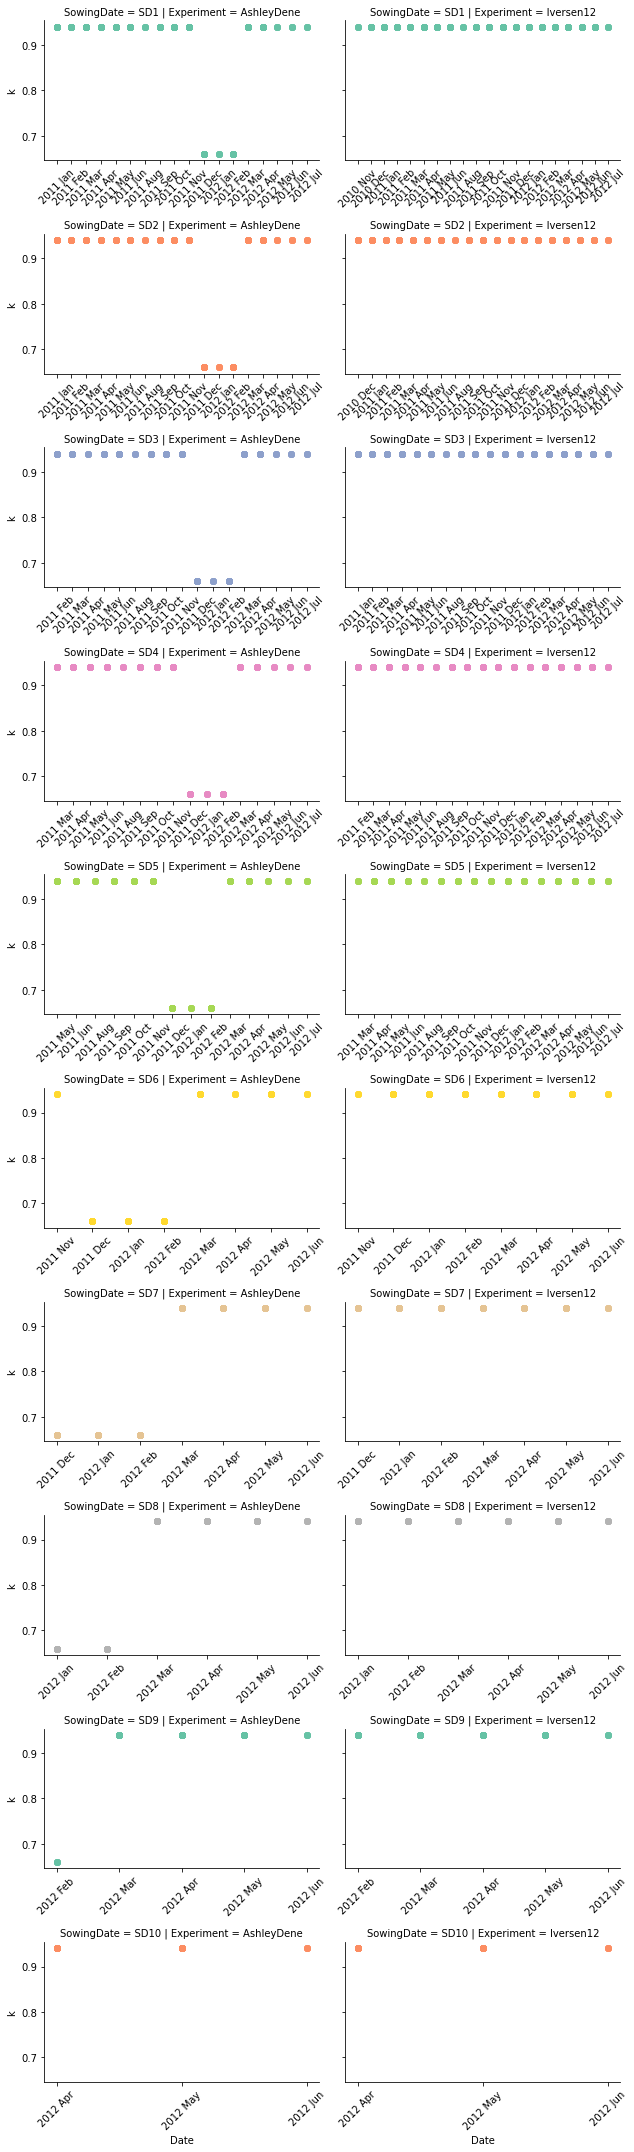

In [9]:
# Check if the replace take effect
grid = sns.FacetGrid(LAI_Height, col ='Experiment', row = 'SowingDate', 
                      hue="SowingDate", palette="Set2",aspect=1.5, sharex=False)
grid.map(plt.scatter, 'Date', 'k')
grid.set_xticklabels(rotation=45)
grid.fig.tight_layout()

# Note at 20200601

The slurp seems not allow users to access [Slurp].Leaf.CoverTotal     
The setupvariable manager script is calculating LAI to feed into the model with a fixed $k$ value

In [10]:
LAI_Height

,Experiment,Clock.Today,SowingDate,Rep,Plot,Rotation.No.,Harvest.No.,Height,LAImod,k,Date
0,AshleyDene,2011-01-04,SD1,1.0,8.0,1.0,1,NaN,0.514157,0.94,2011 Jan
1,AshleyDene,2011-01-04,SD1,2.0,32.0,1.0,1,NaN,0.253992,0.94,2011 Jan
2,AshleyDene,2011-01-04,SD1,3.0,50.0,1.0,1,NaN,0.347268,0.94,2011 Jan
3,AshleyDene,2011-01-04,SD1,4.0,73.0,1.0,1,NaN,0.279894,0.94,2011 Jan
4,AshleyDene,2011-01-14,SD1,1.0,8.0,1.0,2,NaN,0.454804,0.94,2011 Jan
...,...,...,...,...,...,...,...,...,...,...,...
3119,Iversen12,2012-05-30,SD10,4.0,100.0,1.0,6,NaN,2.109737,0.94,2012 May
3120,Iversen12,2012-06-13,SD10,1.0,97.0,1.0,7,NaN,1.300146,0.94,2012 Jun
3121,Iversen12,2012-06-13,SD10,2.0,98.0,1.0,7,NaN,1.500258,0.94,2012 Jun
3122,Iversen12,2012-06-13,SD10,3.0,99.0,1.0,7,NaN,1.436579,0.94,2012 Jun


# Harvest dates

In [11]:
SDs = ['SD' + str(SD) for SD in range(1, 11)]
SDs
LAI_Height.loc[(LAI_Height['Experiment'] == 'AshleyDene')
               & (LAI_Height['SowingDate'] =='SD1') 
               & (LAI_Height['Harvest.No.'] != str(0)), ['Clock.Today','Harvest.No.']].drop_duplicates()

,Clock.Today,Harvest.No.
0,2011-01-04,1
4,2011-01-14,2
8,2011-01-24,3
16,2011-02-10,1
20,2011-02-19,2
25,2011-03-02,3
43,2011-03-15,4
57,2011-03-25,5
75,2011-04-07,6
107,2011-04-28,1


In [12]:
sites = ['AshleyDene', 'Iversen12']
for site in sites: 
    for i in SDs:
        LAI_Height.loc[(LAI_Height['Experiment'] == site) 
                       & (LAI_Height.SowingDate == i)
                       & (LAI_Height['Harvest.No.'] != str(0)),
                       ['Clock.Today','Harvest.No.']].drop_duplicates().to_csv('./03processed-data/CuttingDate' + site + i + '.csv',index = False)

### Observation dates 

**NOTE** Once off output - enable when necessary

In [13]:
# obs_DatesAD = LAI_Height.loc[LAI_Height['Experiment'] == 'AshleyDene', 'Clock.Today'].drop_duplicates()
# obs_DatesAD.to_csv('./03processed-data/ObservationDatesAshleyDene.csv', index = False)
# obs_DatesI12 = LAI_Height.loc[LAI_Height['Experiment'] != 'AshleyDene', 'Clock.Today'].drop_duplicates()
# obs_DatesI12.to_csv('./03processed-data/ObservationDatesIversen12.csv', index = False)

### Output LAI as the slurp input 

In [14]:
SDs = ['SD' + str(SD) for SD in range(1, 11)]
SDs
sites = ['AshleyDene', 'Iversen12']
for site in sites: 
    for i in SDs:
        LAI_Height.loc[(LAI_Height['Experiment'] == site) & (LAI_Height.SowingDate == i),
                       ['Clock.Today', 'LAImod','k']].to_csv('./03processed-data/CoverData/LAI' + site + i + '.csv',index = False)

# Calculate $R/R_0$

In [15]:
LAI_Height['LI_frac'] = 1 - np.exp( - LAI_Height['k'] * LAI_Height['LAImod'])

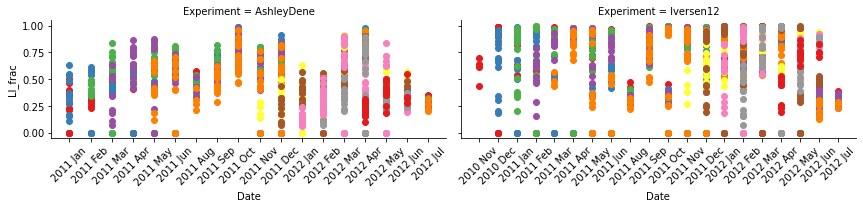

In [16]:
# Check if any weired values. e.g. over 1 or below 0 
grid = sns.FacetGrid(LAI_Height, col ='Experiment',
                      hue="SowingDate", palette="Set1",aspect=2, sharex=False)
grid.map(plt.scatter, 'Date', 'LI_frac')
grid.set_xticklabels(rotation=45)
grid.fig.tight_layout()

## Construct the index

In [17]:
# Select only LI column
LI = LAI_Height.loc[:, ['Experiment', 'Clock.Today','SowingDate', 
                        'Rep', 'Plot', 
                        'LI_frac']]
# print_full(LI)
# remove the rows that have 0S - Likely to be wrong 0s
LI = LI[LI['LI_frac'] != 0.00]
LI

,Experiment,Clock.Today,SowingDate,Rep,Plot,LI_frac
0,AshleyDene,2011-01-04,SD1,1.0,8.0,0.383260
1,AshleyDene,2011-01-04,SD1,2.0,32.0,0.212390
2,AshleyDene,2011-01-04,SD1,3.0,50.0,0.278506
3,AshleyDene,2011-01-04,SD1,4.0,73.0,0.231335
4,AshleyDene,2011-01-14,SD1,1.0,8.0,0.347873
...,...,...,...,...,...,...
3119,Iversen12,2012-05-30,SD10,4.0,100.0,0.862365
3120,Iversen12,2012-06-13,SD10,1.0,97.0,0.705400
3121,Iversen12,2012-06-13,SD10,2.0,98.0,0.755916
3122,Iversen12,2012-06-13,SD10,3.0,99.0,0.740859


In [18]:
LI[LI['SowingDate']=='SD5']

,Experiment,Clock.Today,SowingDate,Rep,Plot,LI_frac
593,AshleyDene,2011-05-13,SD5,1.0,15.0,0.612623
598,AshleyDene,2011-05-13,SD5,2.0,21.0,0.398150
601,AshleyDene,2011-05-13,SD5,3.0,53.0,0.348081
606,AshleyDene,2011-05-13,SD5,4.0,71.0,0.649227
611,AshleyDene,2011-05-18,SD5,1.0,1.0,0.415784
...,...,...,...,...,...,...
2747,Iversen12,2012-06-23,SD5,4.0,80.0,0.258825
2748,Iversen12,2012-07-11,SD5,1.0,1.0,0.269388
2749,Iversen12,2012-07-11,SD5,2.0,34.0,0.287950
2750,Iversen12,2012-07-11,SD5,3.0,47.0,0.226430


In [19]:
LI = LI.pivot_table(index = 'Clock.Today', 
                    columns=['Experiment', 'SowingDate', 
                             'Rep', 'Plot'],
                    values = 'LI_frac')
LI

Experiment  AshleyDene                                                   \
SowingDate         SD1                                   SD10             
Rep                1.0       2.0       3.0      4.0       1.0       2.0   
Plot             8.0       32.0      50.0     73.0      97.0      98.0    
Clock.Today                                                               
2010-11-25         NaN       NaN       NaN      NaN       NaN       NaN   
2010-12-01         NaN       NaN       NaN      NaN       NaN       NaN   
2010-12-07         NaN       NaN       NaN      NaN       NaN       NaN   
2010-12-14         NaN       NaN       NaN      NaN       NaN       NaN   
2010-12-21         NaN       NaN       NaN      NaN       NaN       NaN   
...                ...       ...       ...      ...       ...       ...   
2012-06-05         NaN       NaN       NaN      NaN       NaN       NaN   
2012-06-11    0.276945  0.394655  0.366789  0.33359       NaN       NaN   
2012-06-13         NaN       NaN       NaN      NaN  0.337331  0.322738   
2012-06-23         NaN       NaN       NaN      NaN       NaN       NaN   
2012-07-11    0.300913  0.313271  0.354642  0.34470       NaN       NaN   

Experiment                                          ... Iversen12            \
SowingDate                           SD2            ...       SD7             
Rep               3.0      4.0       1.0       2.0  ...       3.0       4.0   
Plot            99.0     100.0     17.0      33.0   ...     87.0      88.0    
Clock.Today                                         ...                       
2010-11-25        NaN      NaN       NaN       NaN  ...       NaN       NaN   
2010-12-01        NaN      NaN       NaN       NaN  ...       NaN       NaN   
2010-12-07        NaN      NaN       NaN       NaN  ...       NaN       NaN   
2010-12-14        NaN      NaN       NaN       NaN  ...       NaN       NaN   
2010-12-21        NaN      NaN       NaN       NaN  ...       NaN       NaN   
...               ...      ...       ...       ...  ...       ...       ...   
2012-06-05        NaN      NaN       NaN       NaN  ...       NaN       NaN   
2012-06-11        NaN      NaN  0.358761  0.386543  ...       NaN       NaN   
2012-06-13   0.274586  0.54559       NaN       NaN  ...  0.456895  0.514337   
2012-06-23        NaN      NaN       NaN       NaN  ...       NaN       NaN   
2012-07-11        NaN      NaN  0.242533  0.319577  ...       NaN       NaN   

Experiment                                                               \
SowingDate        SD8                                     SD9             
Rep               1.0       2.0       3.0       4.0       1.0       2.0   
Plot            89.0      90.0      91.0      92.0      93.0      94.0    
Clock.Today                                                               
2010-11-25        NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-01        NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-07        NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-14        NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-21        NaN       NaN       NaN       NaN       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
2012-06-05        NaN       NaN       NaN       NaN       NaN       NaN   
2012-06-11        NaN       NaN       NaN       NaN       NaN       NaN   
2012-06-13   0.923112  0.887975  0.905424  0.804831  0.844526  0.889406   
2012-06-23        NaN       NaN       NaN       NaN       NaN       NaN   
2012-07-11        NaN       NaN       NaN       NaN       NaN       NaN   

Experiment                       
SowingDate                       
Rep               3.0       4.0  
Plot            95.0      96.0   
Clock.Today                      
2010-11-25        NaN       NaN  
2010-12-01        NaN       NaN  
2010-12-07        NaN       NaN  
2010-12-14        NaN       NaN  
2010-12-21        NaN      

In [20]:
# Check if the mean values capture all the harvest for SD5 
# SD5 has extra measurments in plot 15, 21,53,71
print_full(LI.filter(regex = 'SD5').groupby(axis = 1, level = ['Experiment','SowingDate']).mean())


Experiment  AshleyDene Iversen12
SowingDate         SD5       SD5
Clock.Today                     
2010-11-25         NaN       NaN
2010-12-01         NaN       NaN
2010-12-07         NaN       NaN
2010-12-14         NaN       NaN
2010-12-21         NaN       NaN
2010-12-28         NaN       NaN
2011-01-04         NaN       NaN
2011-01-07         NaN       NaN
2011-01-14         NaN       NaN
2011-01-20         NaN       NaN
2011-01-21         NaN       NaN
2011-01-24         NaN       NaN
2011-01-28         NaN       NaN
2011-01-30         NaN       NaN
2011-02-03         NaN       NaN
2011-02-07         NaN       NaN
2011-02-08         NaN       NaN
2011-02-10         NaN       NaN
2011-02-11         NaN       NaN
2011-02-15         NaN       NaN
2011-02-17         NaN       NaN
2011-02-19         NaN       NaN
2011-02-21         NaN       NaN
2011-02-27         NaN       NaN
2011-02-28         NaN       NaN
2011-03-01         NaN       NaN
2011-03-02         NaN       NaN
2011-03-03

In [21]:
# Change the index to datetime tyep
LI.index = pd.to_datetime(LI.index)
# Rename the index name 
LI.index.name = 'Clock.Today'
# Normalise the datetime to midnight 
LI.index = LI.index.normalize()

In [22]:
# Check indexs
LI.axes

[DatetimeIndex(['2010-11-25', '2010-12-01', '2010-12-07', '2010-12-14',
                '2010-12-21', '2010-12-28', '2011-01-04', '2011-01-07',
                '2011-01-14', '2011-01-20',
                ...
                '2012-05-14', '2012-05-16', '2012-05-23', '2012-05-28',
                '2012-05-30', '2012-06-05', '2012-06-11', '2012-06-13',
                '2012-06-23', '2012-07-11'],
               dtype='datetime64[ns]', name='Clock.Today', length=151, freq=None),
 MultiIndex([('AshleyDene',  'SD1', 1.0,   8.0),
             ('AshleyDene',  'SD1', 2.0,  32.0),
             ('AshleyDene',  'SD1', 3.0,  50.0),
             ('AshleyDene',  'SD1', 4.0,  73.0),
             ('AshleyDene', 'SD10', 1.0,  97.0),
             ('AshleyDene', 'SD10', 2.0,  98.0),
             ('AshleyDene', 'SD10', 3.0,  99.0),
             ('AshleyDene', 'SD10', 4.0, 100.0),
             ('AshleyDene',  'SD2', 1.0,  17.0),
             ('AshleyDene',  'SD2', 2.0,  33.0),
             ('AshleyDene',  '

## Calcuate the mean LI_frac

In [23]:
LIGroupedMean = LI.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()

In [24]:
LIGroupedMean

Experiment  AshleyDene                                                    \
SowingDate         SD1      SD10       SD2       SD3       SD4       SD5   
Clock.Today                                                                
2010-11-25         NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-01         NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-07         NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-14         NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-21         NaN       NaN       NaN       NaN       NaN       NaN   
...                ...       ...       ...       ...       ...       ...   
2012-06-05         NaN       NaN       NaN       NaN       NaN       NaN   
2012-06-11    0.342995       NaN  0.362233  0.372487  0.298059  0.294200   
2012-06-13         NaN  0.370061       NaN       NaN       NaN       NaN   
2012-06-23         NaN       NaN       NaN       NaN       NaN       NaN   
2012-07-11    0.328381       NaN  0.276763  0.278141  0.248774  0.250505   

Experiment                                          Iversen12            \
SowingDate        SD6       SD7       SD8       SD9       SD1      SD10   
Clock.Today                                                               
2010-11-25        NaN       NaN       NaN       NaN  0.596230       NaN   
2010-12-01        NaN       NaN       NaN       NaN  0.910097       NaN   
2010-12-07        NaN       NaN       NaN       NaN  0.968894       NaN   
2010-12-14        NaN       NaN       NaN       NaN  0.980666       NaN   
2010-12-21        NaN       NaN       NaN       NaN  0.984445       NaN   
...               ...       ...       ...       ...       ...       ...   
2012-06-05        NaN       NaN       NaN       NaN  0.308923       NaN   
2012-06-11        NaN       NaN       NaN       NaN       NaN       NaN   
2012-06-13   0.502636  0.400498  0.237488  0.308638       NaN  0.757172   
2012-06-23        NaN       NaN       NaN       NaN  0.434479       NaN   
2012-07-11        NaN       NaN       NaN       NaN  0.341186       NaN   

Experiment                                                               \
SowingDate        SD2       SD3       SD4       SD5       SD6       SD7   
Clock.Today                                                               
2010-11-25        NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-01        NaN       NaN       NaN       NaN       NaN       NaN   
2010-12-07   0.258140       NaN       NaN       NaN       NaN       NaN   
2010-12-14   0.662138       NaN       NaN       NaN       NaN       NaN   
2010-12-21   0.747456       NaN       NaN       NaN       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
2012-06-05   0.281106  0.263859  0.216149  0.182023       NaN       NaN   
2012-06-11        NaN       NaN       NaN       NaN       NaN       NaN   
2012-06-13        NaN       NaN       NaN       NaN  0.924095  0.496515   
2012-06-23   0.382035  0.405570  0.333794  0.254870       NaN       NaN   
2012-07-11   0.266244  0.333818  0.334901  0.265695       NaN       NaN   

Experiment                       
SowingDate        SD8       SD9  
Clock.Today                      
2010-11-25        NaN       NaN  
2010-12-01        NaN       NaN  
2010-12-07        NaN       NaN  
2010-12-14        NaN       NaN  
2010-12-21        NaN       NaN  
...               ...       ...  
2012-06-05        NaN       NaN  
2012-06-11        NaN       NaN  
2012-06-13   0.880336  0.862755  
2012-06-23        NaN       NaN  
2012-07-11        NaN       NaN  

[151 rows x 20 columns]

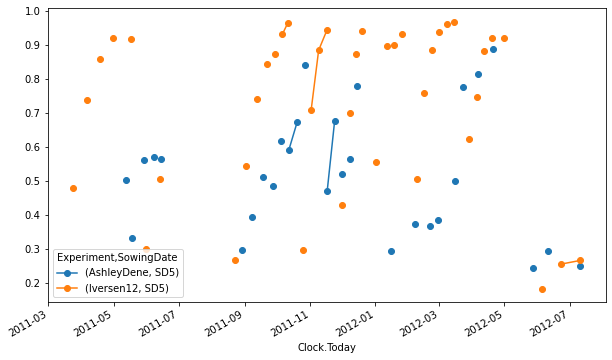

In [25]:
# Graph to check the data 

LIGroupedMean.loc[:,
                  [X for X in LIGroupedMean.columns if 'SD5' in X]].plot(figsize=(10, 6),style='o-')


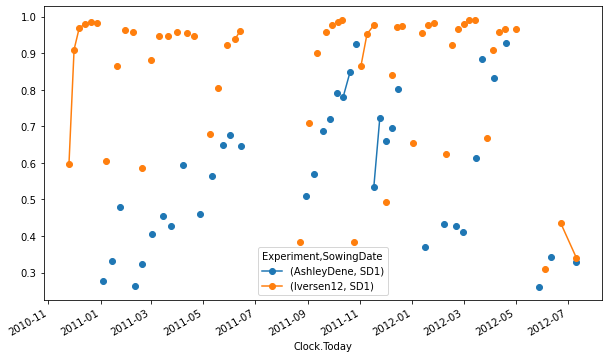

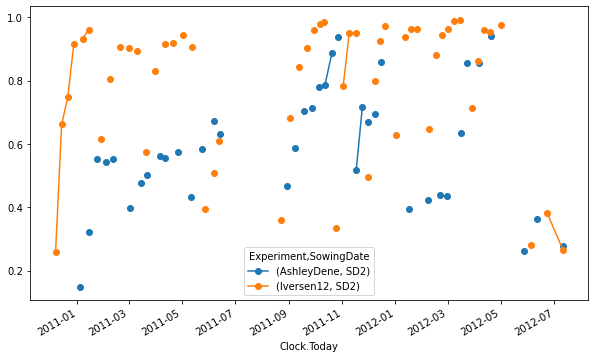

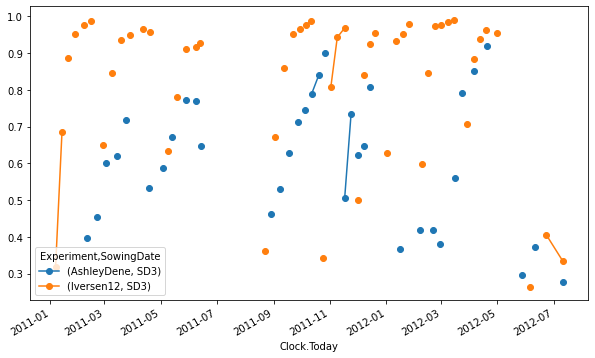

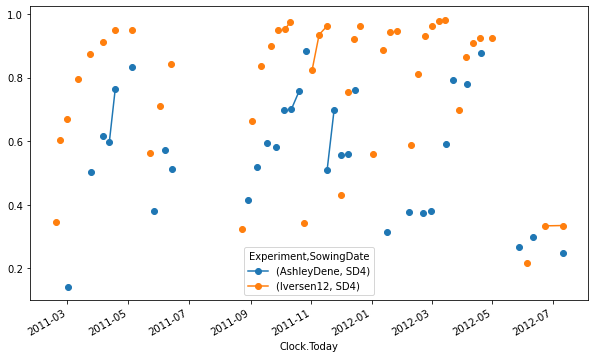

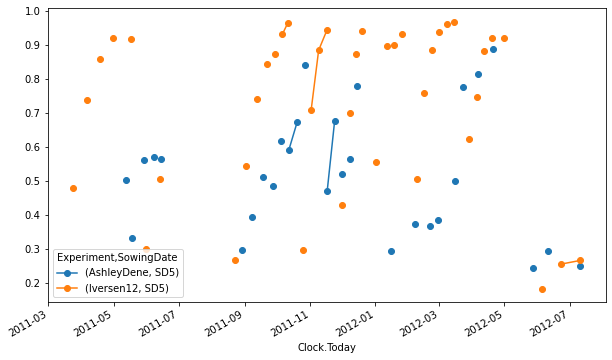

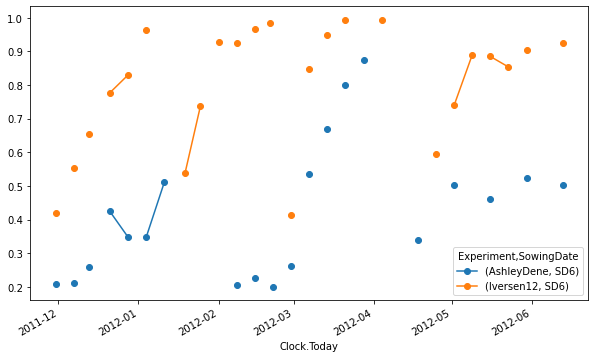

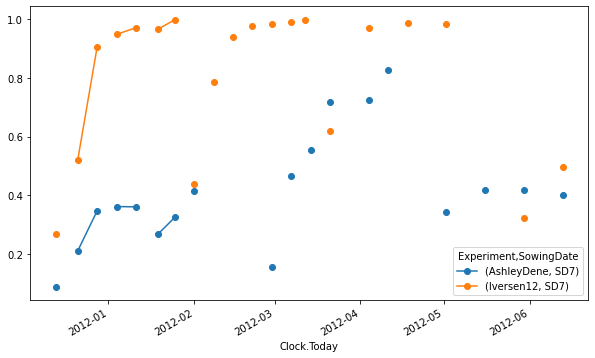

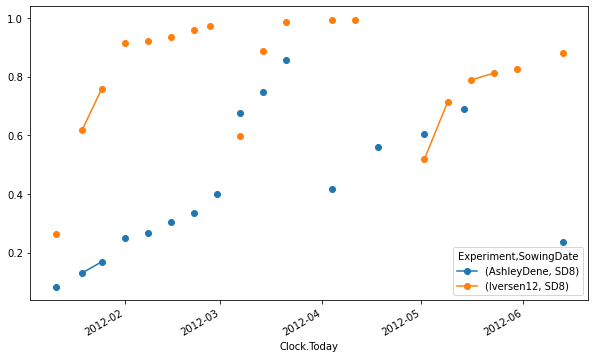

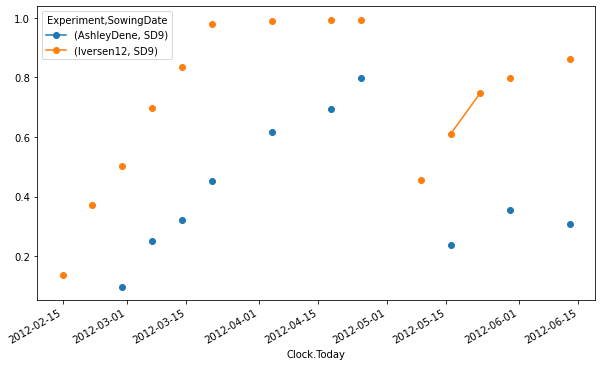

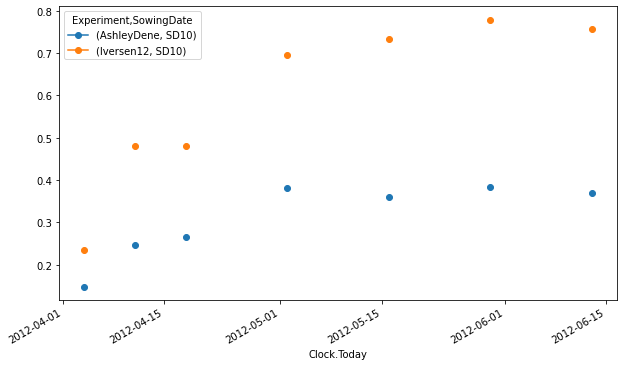

In [26]:
SDs = ['SD' + str(SD) for SD in range(1, 11)]
for i in SDs:
    LIGroupedMean.loc[:,
                  [X for X in LIGroupedMean.columns if i in X]].plot(figsize=(10, 6),style='o-')

# Met data to calculate thermal time 

In [27]:
met_AD = met_AD.loc[:, ['year','day', 'maxt', 'mint','mean']]
met_AD['Experiment'] = 'AshleyDene'
met_I12 = met_I12.loc[(met_I12['year'] >= 2010)                       
                      & (met_I12['year'] < 2013), ['year','day', 'maxt', 'mint','mean']]
met_I12['Experiment'] = 'Iversen12'

In [28]:
met = pd.concat([met_AD, met_I12], ignore_index=True)

In [29]:
# Change 4 digits year to the first date of the year
met['year'] = [str(year) + '-01-01' for year in met['year']]
met['year'] = pd.to_datetime(met['year'])
# Change the day to a delta days and add back to the year 
met['Clock.Today'] = met['year'] + pd.to_timedelta(met['day'], unit='D')

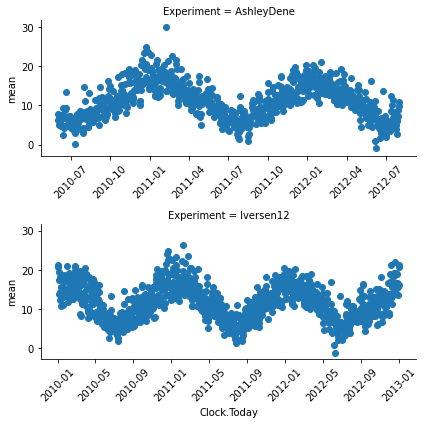

In [30]:
# Check if any weired values. 
grid = sns.FacetGrid(met, row ='Experiment',
                     aspect=2, sharex=False)
grid.map(plt.scatter, 'Clock.Today', 'mean')
grid.set_xticklabels(rotation=45)
grid.fig.tight_layout()

#### Note:   
1. The iversen 12 met has a long period of coverage.
   Expt period: **October 2010 to July 2012.**
   

In [31]:
met = met[(met['Clock.Today'] > '2010-06-01')
          &(met['Clock.Today'] < '2012-08-01')]


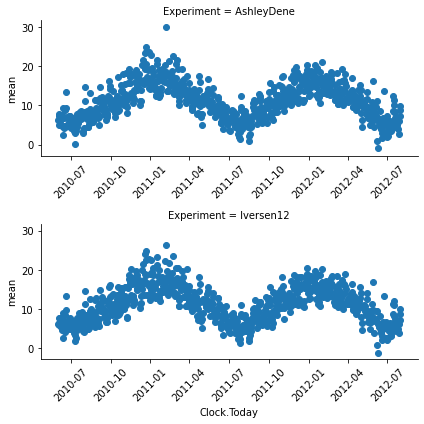

In [32]:
# Verify the filter 
# Check if any weired values. 
grid = sns.FacetGrid(met, row ='Experiment',
                     aspect=2, sharex=False)
grid.map(plt.scatter, 'Clock.Today', 'mean')
grid.set_xticklabels(rotation=45)
grid.fig.tight_layout()

In [33]:
# indexing 
met.set_index('Clock.Today', inplace = True)

In [34]:
print_full(met)

                  year  day  maxt  mint   mean  Experiment
Clock.Today                                               
2010-06-02  2010-01-01  152   8.4   3.9   6.20  AshleyDene
2010-06-03  2010-01-01  153   9.2   5.9   7.70  AshleyDene
2010-06-04  2010-01-01  154  11.4   1.4   7.40  AshleyDene
2010-06-05  2010-01-01  155  12.8  -0.8   5.10  AshleyDene
2010-06-06  2010-01-01  156  12.2   3.8   7.50  AshleyDene
2010-06-07  2010-01-01  157  10.0   2.8   6.00  AshleyDene
2010-06-08  2010-01-01  158   7.8   5.5   7.00  AshleyDene
2010-06-09  2010-01-01  159   7.7   3.3   5.10  AshleyDene
2010-06-10  2010-01-01  160   9.5   0.2   4.70  AshleyDene
2010-06-11  2010-01-01  161  11.7   2.1   6.90  AshleyDene
2010-06-12  2010-01-01  162  11.9   3.5   7.60  AshleyDene
2010-06-13  2010-01-01  163  13.6   5.4   9.30  AshleyDene
2010-06-14  2010-01-01  164   6.1  -1.0   2.40  AshleyDene
2010-06-15  2010-01-01  165  11.8  -1.9   4.20  AshleyDene
2010-06-16  2010-01-01  166  10.0   3.7   6.80  AshleyDe

In [35]:
# Try 2 sites the same time 
ThermalTimeAccum = met.loc[:, 'mean'].cumsum()
ThermalTimeAccum.index = pd.to_datetime(ThermalTimeAccum.index)

## Combine thermal time with cover data

In [36]:
#Reindex coverdata frame to daily values
LIDaily = LI.reindex(ThermalTimeAccum.index)
LIDaily.loc[:, 'AccumTT'] = ThermalTimeAccum
# CoverDataDaily.loc[:,'AccumTT'] = ThermalTimeAccum

In [37]:
print_full(LIDaily.filter(regex='SD5'))

Experiment  AshleyDene                                                    \
SowingDate         SD5                                                     
Rep                1.0                 2.0                 3.0             
Plot              1.0       15.0      21.0      34.0      47.0      53.0   
Clock.Today                                                                
2010-06-02         NaN       NaN       NaN       NaN       NaN       NaN   
2010-06-03         NaN       NaN       NaN       NaN       NaN       NaN   
2010-06-04         NaN       NaN       NaN       NaN       NaN       NaN   
2010-06-05         NaN       NaN       NaN       NaN       NaN       NaN   
2010-06-06         NaN       NaN       NaN       NaN       NaN       NaN   
2010-06-07         NaN       NaN       NaN       NaN       NaN       NaN   
2010-06-08         NaN       NaN       NaN       NaN       NaN       NaN   
2010-06-09         NaN       NaN       NaN       NaN       NaN       NaN   
2010-06-10  

## Interpolate daily values 

**Note**  
The for loop below complains _ValueError: fp and xp are not of the same length._  

This is probably because the LI is in a wide form 
But the thermal data is in a long form which includs two sites 


In [38]:
# for p in LIDaily.columns:
#     Obs = LIDaily.loc[:,p].dropna()
#     LIDaily.loc[:,p] = np.interp(LIDaily.AccumTT, LIDaily.loc[Obs.index,'AccumTT'],Obs)

## Process sites individually   

Ashley Dene first

In [39]:
LIAD = LI.filter(regex = 'Ashley')
#Reindex coverdata frame to daily values
TTAccumAD = met.loc[met['Experiment'] == 'AshleyDene', 'mean'].cumsum()
TTAccumAD.index = pd.to_datetime(TTAccumAD.index)

LIDailyAD = LIAD.reindex(TTAccumAD.index)
LIDailyAD.loc[:, 'AccumTT'] = TTAccumAD


In [40]:
LIDailyAD 

Experiment  AshleyDene                                                ...  \
SowingDate         SD1                SD10                  SD2       ...   
Rep                1.0  2.0  3.0  4.0  1.0  2.0  3.0   4.0  1.0  2.0  ...   
Plot               8.0 32.0 50.0 73.0 97.0 98.0 99.0 100.0 17.0 33.0  ...   
Clock.Today                                                           ...   
2010-06-02         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2010-06-03         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2010-06-04         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2010-06-05         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2010-06-06         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
...                ...  ...  ...  ...  ...  ...  ...   ...  ...  ...  ...   
2012-07-27         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2012-07-28         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2012-07-29         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2012-07-30         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2012-07-31         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   

Experiment                                               AccumTT  
SowingDate   SD7  SD8                 SD9                         
Rep          4.0  1.0  2.0  3.0  4.0  1.0  2.0  3.0  4.0          
Plot        88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0          
Clock.Today                                                       
2010-06-02   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     6.2  
2010-06-03   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    13.9  
2010-06-04   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    21.3  
2010-06-05   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    26.4  
2010-06-06   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    33.9  
...          ...  ...  ...  ...  ...  ...  ...  ...  ...     ...  
2012-07-27   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8725.4  
2012-07-28   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8731.5  
2012-07-29   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8738.8  
2012-07-30   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8747.6  
2012-07-31   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8757.4  

[791 rows x 49 columns]

In [41]:
## Disabled because not making sense to have a starting LI 0.3 over
# for p in LIDailyAD.columns:
#     Obs = LIDailyAD.loc[:,p].dropna()
#     LIDailyAD.loc[:,p] = np.interp(LIDailyAD.AccumTT,
#                                    LIDailyAD.loc[Obs.index,'AccumTT'],Obs)

In [42]:
LIDailyAD

Experiment  AshleyDene                                                ...  \
SowingDate         SD1                SD10                  SD2       ...   
Rep                1.0  2.0  3.0  4.0  1.0  2.0  3.0   4.0  1.0  2.0  ...   
Plot               8.0 32.0 50.0 73.0 97.0 98.0 99.0 100.0 17.0 33.0  ...   
Clock.Today                                                           ...   
2010-06-02         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2010-06-03         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2010-06-04         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2010-06-05         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2010-06-06         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
...                ...  ...  ...  ...  ...  ...  ...   ...  ...  ...  ...   
2012-07-27         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2012-07-28         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2012-07-29         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2012-07-30         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   
2012-07-31         NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...   

Experiment                                               AccumTT  
SowingDate   SD7  SD8                 SD9                         
Rep          4.0  1.0  2.0  3.0  4.0  1.0  2.0  3.0  4.0          
Plot        88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0          
Clock.Today                                                       
2010-06-02   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     6.2  
2010-06-03   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    13.9  
2010-06-04   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    21.3  
2010-06-05   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    26.4  
2010-06-06   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    33.9  
...          ...  ...  ...  ...  ...  ...  ...  ...  ...     ...  
2012-07-27   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8725.4  
2012-07-28   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8731.5  
2012-07-29   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8738.8  
2012-07-30   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8747.6  
2012-07-31   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8757.4  

[791 rows x 49 columns]

In [43]:
LIGroupedMeanAD = LIDailyAD.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()

In [44]:
LIGroupedMeanAD.columns

MultiIndex([('AshleyDene',  'SD1'),
            ('AshleyDene', 'SD10'),
            ('AshleyDene',  'SD2'),
            ('AshleyDene',  'SD3'),
            ('AshleyDene',  'SD4'),
            ('AshleyDene',  'SD5'),
            ('AshleyDene',  'SD6'),
            ('AshleyDene',  'SD7'),
            ('AshleyDene',  'SD8'),
            ('AshleyDene',  'SD9'),
            (   'AccumTT',     '')],
           names=['Experiment', 'SowingDate'])

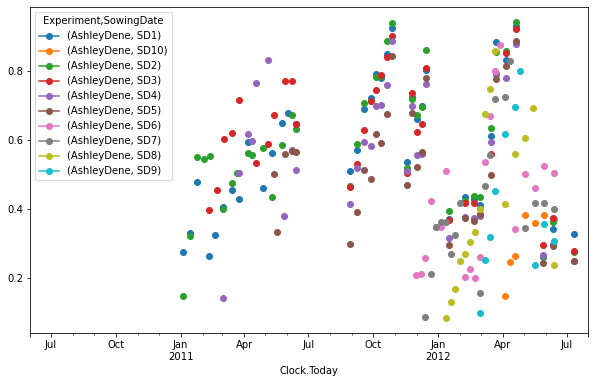

In [45]:
# Graph to check the data 
LIGroupedMeanAD.loc[:,
                  [X for X in LIGroupedMeanAD.columns if X != (   'AccumTT',     '')]].plot(figsize=(10, 6),style='o-')

#### Notes

MAYBE the starting point need to be forced to be 0

## Iversen12 LI interpolate

In [46]:
LII12 = LI.filter(regex = 'Ive')

TTAccumI12 = met.loc[met['Experiment'] == 'Iversen12', 'mean'].cumsum()
TTAccumI12.index = pd.to_datetime(TTAccumI12.index)
LIDailyI12 = LII12.reindex(TTAccumI12.index)  #Reindex coverdata frame to daily values
LIDailyI12.loc[:,'AccumTT'] = TTAccumI12
# Disabled as well 
for p in LIDailyI12.columns:
    Obs = LIDailyI12.loc[:,p].dropna()
    LIDailyI12.loc[:,p] = np.interp(LIDailyI12.AccumTT,
                                   LIDailyI12.loc[Obs.index,'AccumTT'],Obs)
LIGroupedMeanI12 = LIDailyI12.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()

In [47]:
LIGroupedMeanI12.columns

MultiIndex([('Iversen12',  'SD1'),
            ('Iversen12', 'SD10'),
            ('Iversen12',  'SD2'),
            ('Iversen12',  'SD3'),
            ('Iversen12',  'SD4'),
            ('Iversen12',  'SD5'),
            ('Iversen12',  'SD6'),
            ('Iversen12',  'SD7'),
            ('Iversen12',  'SD8'),
            ('Iversen12',  'SD9'),
            (  'AccumTT',     '')],
           names=['Experiment', 'SowingDate'])

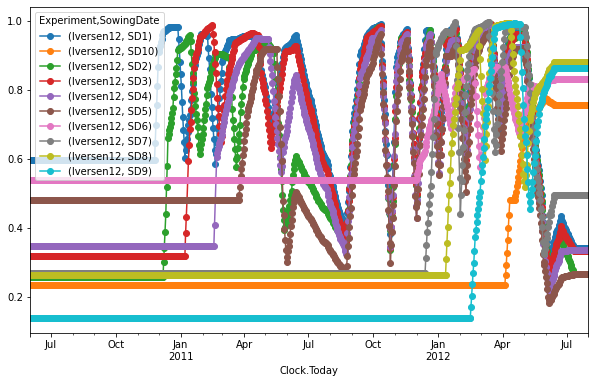

In [48]:
# Graph to check the data 
LIGroupedMeanI12.loc[:,
                  [X for X in LIGroupedMeanI12.columns if X != (   'AccumTT',     '')]].plot(figsize=(10, 6),style='o-')

# Force the starting point to be 0

In [49]:
sowingdates = pd.read_sql('Select * from SowingDates',  con)

In [50]:
sowingdates.AD = pd.to_datetime(sowingdates.AD)
sowingdates.I12 = pd.to_datetime(sowingdates.I12)


In [51]:
# set index and rename columns 
sowingdates.set_index('SD', inplace=True)
sowingdates.columns = ['AshleyDene', 'Iversen12']

In [52]:
sowingdates.loc
LIDailyAD.axes

[DatetimeIndex(['2010-06-02', '2010-06-03', '2010-06-04', '2010-06-05',
                '2010-06-06', '2010-06-07', '2010-06-08', '2010-06-09',
                '2010-06-10', '2010-06-11',
                ...
                '2012-07-22', '2012-07-23', '2012-07-24', '2012-07-25',
                '2012-07-26', '2012-07-27', '2012-07-28', '2012-07-29',
                '2012-07-30', '2012-07-31'],
               dtype='datetime64[ns]', name='Clock.Today', length=791, freq=None),
 MultiIndex([('AshleyDene',  'SD1', 1.0,   8.0),
             ('AshleyDene',  'SD1', 2.0,  32.0),
             ('AshleyDene',  'SD1', 3.0,  50.0),
             ('AshleyDene',  'SD1', 4.0,  73.0),
             ('AshleyDene', 'SD10', 1.0,  97.0),
             ('AshleyDene', 'SD10', 2.0,  98.0),
             ('AshleyDene', 'SD10', 3.0,  99.0),
             ('AshleyDene', 'SD10', 4.0, 100.0),
             ('AshleyDene',  'SD2', 1.0,  17.0),
             ('AshleyDene',  'SD2', 2.0,  33.0),
             ('AshleyDene',  '

In [53]:
LIAD = LI.filter(regex = 'Ashley')
#Reindex coverdata frame to daily values
TTAccumAD = met.loc[met['Experiment'] == 'AshleyDene', 'mean'].cumsum()
TTAccumAD.index = pd.to_datetime(TTAccumAD.index)

LIDailyAD = LIAD.reindex(TTAccumAD.index)
LIDailyAD.loc[:, 'AccumTT'] = TTAccumAD

In [54]:
idx = pd.IndexSlice
LIDailyAD.loc[LIDailyAD.index == '2012-06-02', idx[:,'SD1']]

Experiment  AshleyDene               
SowingDate         SD1               
Rep                1.0  2.0  3.0  4.0
Plot              8.0  32.0 50.0 73.0
Clock.Today                          
2012-06-02         NaN  NaN  NaN  NaN

In [55]:
for sd in sowingdates.index:
    # Select the date for correpond sowing date
    date0 = sowingdates.at[sd, 'AshleyDene']
    # A slicer
    idx = pd.IndexSlice
    # Replace the row values with 0s
    LIDailyAD.loc[LIDailyAD.index <= date0, idx[:,sd]] = float(0.001)
    # Verification 
    df = LIDailyAD.loc[LIDailyAD.index == date0, idx[:,sd]]
    print('\r')
    print(date0)     
    print(df)


2010-10-21 00:00:00
Experiment  AshleyDene                     
SowingDate         SD1                     
Rep                1.0    2.0    3.0    4.0
Plot              8.0    32.0   50.0   73.0
Clock.Today                                
2010-10-21       0.001  0.001  0.001  0.001

2010-11-09 00:00:00
Experiment  AshleyDene                     
SowingDate         SD2                     
Rep                1.0    2.0    3.0    4.0
Plot              17.0   33.0   51.0   69.0
Clock.Today                                
2010-11-09       0.001  0.001  0.001  0.001

2010-12-08 00:00:00
Experiment  AshleyDene                     
SowingDate         SD3                     
Rep                1.0    2.0    3.0    4.0
Plot              19.0   30.0   44.0   67.0
Clock.Today                                
2010-12-08       0.001  0.001  0.001  0.001

2011-01-13 00:00:00
Experiment  AshleyDene                     
SowingDate         SD4                     
Rep                1.0    2.0    3.0

#### Note   
There are still more than 4 plots for each sowing dates   
Due to seed line and harvest.no.  
The harvest.no **post** did not contribute to LAI. so should taken out.   
The Thermaltime df has duplicated the index.

In [56]:
LIDailyAD

Experiment  AshleyDene                                                   \
SowingDate         SD1                        SD10                        
Rep                1.0    2.0    3.0    4.0    1.0    2.0    3.0    4.0   
Plot               8.0   32.0   50.0   73.0   97.0   98.0   99.0  100.0   
Clock.Today                                                               
2010-06-02       0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001   
2010-06-03       0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001   
2010-06-04       0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001   
2010-06-05       0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001   
2010-06-06       0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001   
...                ...    ...    ...    ...    ...    ...    ...    ...   
2012-07-27         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2012-07-28         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2012-07-29         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2012-07-30         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2012-07-31         NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

Experiment                 ...                                            \
SowingDate     SD2         ...    SD7    SD8                         SD9   
Rep            1.0    2.0  ...    4.0    1.0    2.0    3.0    4.0    1.0   
Plot          17.0   33.0  ...   88.0   89.0   90.0   91.0   92.0   93.0   
Clock.Today                ...                                             
2010-06-02   0.001  0.001  ...  0.001  0.001  0.001  0.001  0.001  0.001   
2010-06-03   0.001  0.001  ...  0.001  0.001  0.001  0.001  0.001  0.001   
2010-06-04   0.001  0.001  ...  0.001  0.001  0.001  0.001  0.001  0.001   
2010-06-05   0.001  0.001  ...  0.001  0.001  0.001  0.001  0.001  0.001   
2010-06-06   0.001  0.001  ...  0.001  0.001  0.001  0.001  0.001  0.001   
...            ...    ...  ...    ...    ...    ...    ...    ...    ...   
2012-07-27     NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
2012-07-28     NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
2012-07-29     NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
2012-07-30     NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   
2012-07-31     NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN   

Experiment                       AccumTT  
SowingDate                                
Rep            2.0    3.0    4.0          
Plot          94.0   95.0   96.0          
Clock.Today                               
2010-06-02   0.001  0.001  0.001     6.2  
2010-06-03   0.001  0.001  0.001    13.9  
2010-06-04   0.001  0.001  0.001    21.3  
2010-06-05   0.001  0.001  0.001    26.4  
2010-06-06   0.001  0.001  0.001    33.9  
...            ...    ...    ...     ...  
2012-07-27     NaN    NaN    NaN  8725.4  
2012-07-28     NaN    NaN    NaN  8731.5  
2012-07-29     NaN    NaN    NaN  8738.8  
2012-07-30     NaN    NaN    NaN  8747.6  
2012-07-31     NaN    NaN    NaN  8757.4  

[791 rows x 49 columns]

In [57]:
for p in LIDailyAD.columns:
    Obs = LIDailyAD.loc[:,p].dropna()
    LIDailyAD.loc[:,p] = np.interp(LIDailyAD.AccumTT,
                                   LIDailyAD.loc[Obs.index,'AccumTT'],Obs)

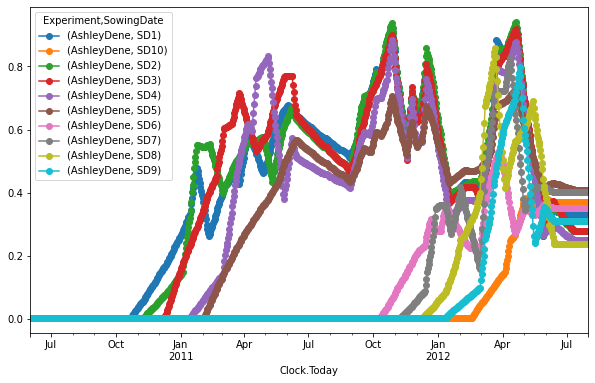

In [58]:
LIGroupedMeanADForced = LIDailyAD.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()
# Graph to check the data 
LIGroupedMeanADForced.loc[:,
                          [X for X in LIGroupedMeanADForced.columns if X != (   'AccumTT',     '')]].plot(figsize=(10, 6),style='o-')

plt.savefig('./05figures/StartJune_AD.png', dpi = 300, bbox_inches = 'tight')

#### Repeat for I12


In [59]:
LII12 = LI.filter(regex = 'Ive')

TTAccumI12 = met.loc[met['Experiment'] == 'Iversen12', 'mean'].cumsum()
TTAccumI12.index = pd.to_datetime(TTAccumI12.index)
LIDailyI12 = LII12.reindex(TTAccumI12.index)  #Reindex coverdata frame to daily values
LIDailyI12.loc[:,'AccumTT'] = TTAccumI12


In [60]:
LIDailyI12

Experiment  Iversen12                                                ...       \
SowingDate        SD1                SD10                  SD2       ...  SD7   
Rep               1.0  2.0  3.0  4.0  1.0  2.0  3.0   4.0  1.0  2.0  ...  4.0   
Plot              8.0 32.0 50.0 73.0 97.0 98.0 99.0 100.0 17.0 33.0  ... 88.0   
Clock.Today                                                          ...        
2010-06-02        NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  NaN   
2010-06-03        NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  NaN   
2010-06-04        NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  NaN   
2010-06-05        NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  NaN   
2010-06-06        NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  NaN   
...               ...  ...  ...  ...  ...  ...  ...   ...  ...  ...  ...  ...   
2012-07-27        NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  NaN   
2012-07-28        NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  NaN   
2012-07-29        NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  NaN   
2012-07-30        NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  NaN   
2012-07-31        NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  ...  NaN   

Experiment                                           AccumTT  
SowingDate   SD8                 SD9                          
Rep          1.0  2.0  3.0  4.0  1.0  2.0  3.0  4.0           
Plot        89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0           
Clock.Today                                                   
2010-06-02   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     6.30  
2010-06-03   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    13.90  
2010-06-04   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    20.30  
2010-06-05   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    26.20  
2010-06-06   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN    33.95  
...          ...  ...  ...  ...  ...  ...  ...  ...      ...  
2012-07-27   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8751.65  
2012-07-28   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8757.75  
2012-07-29   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8765.05  
2012-07-30   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8773.85  
2012-07-31   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  8783.75  

[791 rows x 45 columns]

In [61]:
for sd in sowingdates.index:
    # Select the date for correpond sowing date
    date0 = sowingdates.at[sd, 'Iversen12']
    # A slicer
    idx = pd.IndexSlice
    # Replace the row values with 0s
    LIDailyI12.loc[LIDailyI12.index <= date0, idx[:,sd]] = float(0.001)
    # Verification 
    df = LIDailyI12.loc[LIDailyI12.index == date0, idx[:,sd]]
    print('\r')
    print(date0)     
    print(df)


2010-10-04 00:00:00
Experiment  Iversen12                     
SowingDate        SD1                     
Rep               1.0    2.0    3.0    4.0
Plot             8.0    32.0   50.0   73.0
Clock.Today                               
2010-10-04      0.001  0.001  0.001  0.001

2010-11-04 00:00:00
Experiment  Iversen12                     
SowingDate        SD2                     
Rep               1.0    2.0    3.0    4.0
Plot             17.0   33.0   51.0   69.0
Clock.Today                               
2010-11-04      0.001  0.001  0.001  0.001

2010-12-02 00:00:00
Experiment  Iversen12                     
SowingDate        SD3                     
Rep               1.0    2.0    3.0    4.0
Plot             19.0   30.0   44.0   67.0
Clock.Today                               
2010-12-02      0.001  0.001  0.001  0.001

2011-01-10 00:00:00
Experiment  Iversen12                     
SowingDate        SD4                     
Rep               1.0    2.0    3.0    4.0
Plot         

In [62]:
# Interpolate LI daily value by thermal time 
for p in LIDailyI12.columns:
    Obs = LIDailyI12.loc[:,p].dropna()
    LIDailyI12.loc[:,p] = np.interp(LIDailyI12.AccumTT,
                                   LIDailyI12.loc[Obs.index,'AccumTT'],Obs)


In [63]:
LIGroupedMeanI12Forced = LIDailyI12.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()

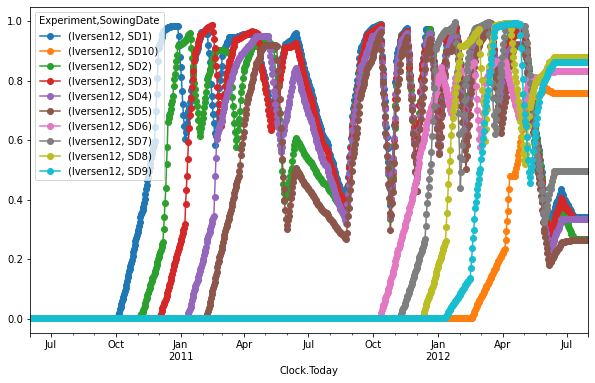

In [64]:
# Graph to check the data 
LIGroupedMeanI12Forced.loc[:,
                           [X for X in LIGroupedMeanI12Forced.columns if X != (   'AccumTT',     '')]].plot(figsize=(10, 6),style='o-')

In [65]:
LIGroupedMeanI12Forced

Experiment  Iversen12                                                    \
SowingDate        SD1      SD10       SD2       SD3       SD4       SD5   
Clock.Today                                                               
2010-06-02   0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
2010-06-03   0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
2010-06-04   0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
2010-06-05   0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
2010-06-06   0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
...               ...       ...       ...       ...       ...       ...   
2012-07-27   0.341186  0.757172  0.266244  0.333818  0.334901  0.265695   
2012-07-28   0.341186  0.757172  0.266244  0.333818  0.334901  0.265695   
2012-07-29   0.341186  0.757172  0.266244  0.333818  0.334901  0.265695   
2012-07-30   0.341186  0.757172  0.266244  0.333818  0.334901  0.265695   
2012-07-31   0.341186  0.757172  0.266244  0.333818  0.334901  0.265695   

Experiment                                           AccumTT  
SowingDate        SD6       SD7       SD8       SD9           
Clock.Today                                                   
2010-06-02   0.001000  0.001000  0.001000  0.001000     6.30  
2010-06-03   0.001000  0.001000  0.001000  0.001000    13.90  
2010-06-04   0.001000  0.001000  0.001000  0.001000    20.30  
2010-06-05   0.001000  0.001000  0.001000  0.001000    26.20  
2010-06-06   0.001000  0.001000  0.001000  0.001000    33.95  
...               ...       ...       ...       ...      ...  
2012-07-27   0.831278  0.496515  0.880336  0.862755  8751.65  
2012-07-28   0.831278  0.496515  0.880336  0.862755  8757.75  
2012-07-29   0.831278  0.496515  0.880336  0.862755  8765.05  
2012-07-30   0.831278  0.496515  0.880336  0.862755  8773.85  
2012-07-31   0.831278  0.496515  0.880336  0.862755  8783.75  

[791 rows x 11 columns]

In [66]:
LIGroupedMeanADForced

Experiment  AshleyDene                                                    \
SowingDate         SD1      SD10       SD2       SD3       SD4       SD5   
Clock.Today                                                                
2010-06-02    0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
2010-06-03    0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
2010-06-04    0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
2010-06-05    0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
2010-06-06    0.001000  0.001000  0.001000  0.001000  0.001000  0.001000   
...                ...       ...       ...       ...       ...       ...   
2012-07-27    0.328381  0.370061  0.276763  0.278141  0.248774  0.409758   
2012-07-28    0.328381  0.370061  0.276763  0.278141  0.248774  0.409758   
2012-07-29    0.328381  0.370061  0.276763  0.278141  0.248774  0.409758   
2012-07-30    0.328381  0.370061  0.276763  0.278141  0.248774  0.409758   
2012-07-31    0.328381  0.370061  0.276763  0.278141  0.248774  0.409758   

Experiment                                          AccumTT  
SowingDate        SD6       SD7       SD8       SD9          
Clock.Today                                                  
2010-06-02   0.001000  0.001000  0.001000  0.001000     6.2  
2010-06-03   0.001000  0.001000  0.001000  0.001000    13.9  
2010-06-04   0.001000  0.001000  0.001000  0.001000    21.3  
2010-06-05   0.001000  0.001000  0.001000  0.001000    26.4  
2010-06-06   0.001000  0.001000  0.001000  0.001000    33.9  
...               ...       ...       ...       ...     ...  
2012-07-27   0.351235  0.400498  0.237488  0.308638  8725.4  
2012-07-28   0.351235  0.400498  0.237488  0.308638  8731.5  
2012-07-29   0.351235  0.400498  0.237488  0.308638  8738.8  
2012-07-30   0.351235  0.400498  0.237488  0.308638  8747.6  
2012-07-31   0.351235  0.400498  0.237488  0.308638  8757.4  

[791 rows x 11 columns]

# Does it make difference by changing the period of met data?

In [67]:
sowingdates

,AshleyDene,Iversen12
SD,,
SD1,2010-10-21,2010-10-04
SD2,2010-11-09,2010-11-04
SD3,2010-12-08,2010-12-02
SD4,2011-01-13,2011-01-10
SD5,2011-02-03,2011-02-07
SD6,2011-10-10,2011-10-10
SD7,2011-11-07,2011-11-07
SD8,2011-12-09,2011-12-09
SD9,2012-01-10,2012-01-10


In [68]:
LIAD = LI.filter(regex = 'Ashley')
#Reindex coverdata frame to daily values
TTAccumAD = met.loc[(met['Experiment'] == 'AshleyDene')
                    & (met.index > '2010-10-20'), 'mean'].cumsum()
TTAccumAD.index = pd.to_datetime(TTAccumAD.index)

LIDailyAD = LIAD.reindex(TTAccumAD.index)
LIDailyAD.loc[:, 'AccumTT'] = TTAccumAD


In [69]:
for sd in sowingdates.index:
    # Select the date for correpond sowing date
    date0 = sowingdates.at[sd, 'AshleyDene']
    # A slicer
    idx = pd.IndexSlice
    # Replace the row values with 0s
    LIDailyAD.loc[LIDailyAD.index <= date0, idx[:,sd]] = float(0.001)
    # Verification 
    df = LIDailyAD.loc[LIDailyAD.index == date0, idx[:,sd]]
for p in LIDailyAD.columns:
    Obs = LIDailyAD.loc[:,p].dropna()
    LIDailyAD.loc[:,p] = np.interp(LIDailyAD.AccumTT,
                                   LIDailyAD.loc[Obs.index,'AccumTT'],Obs)

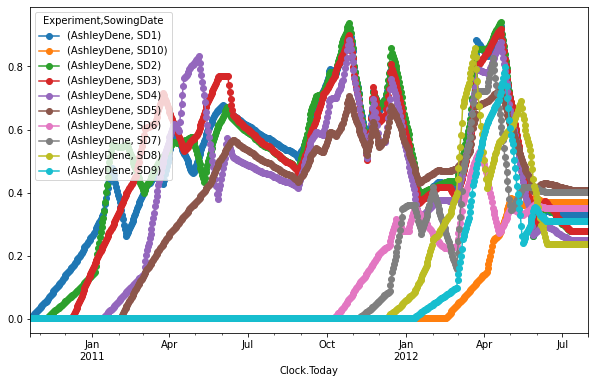

In [70]:
LIGroupedMeanADForced = LIDailyAD.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()
# Graph to check the data 
LIGroupedMeanADForced.loc[:,
                              [X for X in LIGroupedMeanADForced.columns if X != (   'AccumTT',     '')]].plot(figsize=(10, 6),style='o-')
plt.savefig('./05figures/StartSD1_AD.png', dpi = 300, bbox_inches = 'tight')

In [71]:
LII12 = LI.filter(regex = 'Iver')
#Reindex coverdata frame to daily values
TTAccumI12 = met.loc[(met['Experiment'] == 'Iversen12')
                    & (met.index > '2010-10-03'), 'mean'].cumsum()
TTAccumI12.index = pd.to_datetime(TTAccumI12.index)

LIDailyI12 = LII12.reindex(TTAccumI12.index)
LIDailyI12.loc[:, 'AccumTT'] = TTAccumI12
for sd in sowingdates.index:
    # Select the date for correpond sowing date
    date0 = sowingdates.at[sd, 'Iversen12']
    print(date0)
    # A slicer
    idx = pd.IndexSlice
    # Replace the row values with 0s
    LIDailyI12.loc[LIDailyI12.index <= date0, idx[:,sd]] = float(0.001)
#     # Verification 
    df = LIDailyI12.loc[LIDailyI12.index == date0, idx[:,sd]]
#     print(df)
for p in LIDailyI12.columns:
    Obs = LIDailyI12.loc[:,p].dropna()
    LIDailyI12.loc[:,p] = np.interp(LIDailyI12.AccumTT,
                                   LIDailyI12.loc[Obs.index,'AccumTT'],Obs)

2010-10-04 00:00:00
2010-11-04 00:00:00
2010-12-02 00:00:00
2011-01-10 00:00:00
2011-02-07 00:00:00
2011-10-10 00:00:00
2011-11-07 00:00:00
2011-12-09 00:00:00
2012-01-10 00:00:00
2012-02-17 00:00:00


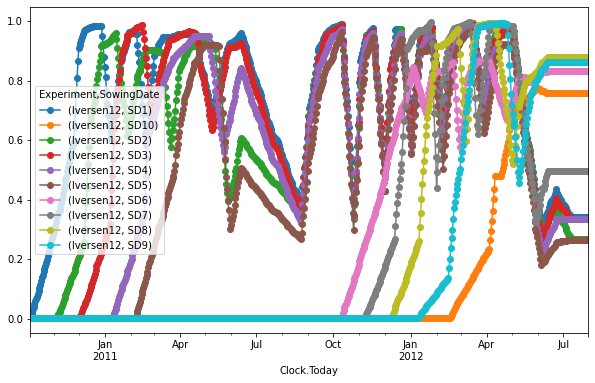

In [72]:
LIGroupedMeanI12Forced = LIDailyI12.groupby(axis=1, level=['Experiment', 'SowingDate']).mean()
# Graph to check the data 
LIGroupedMeanI12Forced.loc[:,
                              [X for X in LIGroupedMeanI12Forced.columns if X != (   'AccumTT',     '')]].plot(figsize=(10, 6),style='o-')
plt.savefig('./05figures/StartSD1_I12.png', dpi = 300, bbox_inches = 'tight')

In [73]:
sowingdates

,AshleyDene,Iversen12
SD,,
SD1,2010-10-21,2010-10-04
SD2,2010-11-09,2010-11-04
SD3,2010-12-08,2010-12-02
SD4,2011-01-13,2011-01-10
SD5,2011-02-03,2011-02-07
SD6,2011-10-10,2011-10-10
SD7,2011-11-07,2011-11-07
SD8,2011-12-09,2011-12-09
SD9,2012-01-10,2012-01-10


#### Seems no difference


# Output the LI DAILY

In [74]:
# Reset the index back to a column
LIGroupedMeanADForced.columns

MultiIndex([('AshleyDene',  'SD1'),
            ('AshleyDene', 'SD10'),
            ('AshleyDene',  'SD2'),
            ('AshleyDene',  'SD3'),
            ('AshleyDene',  'SD4'),
            ('AshleyDene',  'SD5'),
            ('AshleyDene',  'SD6'),
            ('AshleyDene',  'SD7'),
            ('AshleyDene',  'SD8'),
            ('AshleyDene',  'SD9'),
            (   'AccumTT',     '')],
           names=['Experiment', 'SowingDate'])

In [75]:
CoverDF = LIGroupedMeanADForced.drop('AccumTT', axis=1, level=0).stack([0,1]).reset_index()

In [76]:
CoverDF.columns = ['Date', 'Experiment', 'SowingDate', 'LightInterception']
CoverDF

,Date,Experiment,SowingDate,LightInterception
0,2010-10-21,AshleyDene,SD1,0.001000
1,2010-10-21,AshleyDene,SD10,0.001000
2,2010-10-21,AshleyDene,SD2,0.001000
3,2010-10-21,AshleyDene,SD3,0.001000
4,2010-10-21,AshleyDene,SD4,0.001000
...,...,...,...,...
6495,2012-07-31,AshleyDene,SD5,0.409758
6496,2012-07-31,AshleyDene,SD6,0.351235
6497,2012-07-31,AshleyDene,SD7,0.400498
6498,2012-07-31,AshleyDene,SD8,0.237488


In [77]:
# Test
CoverDF.loc[CoverDF.SowingDate == 'SD1', ['Date', 'LightInterception']].to_csv('./03processed-data/CoverData/CoverDataSD1.csv',index = False)

In [78]:
# SDs = ['SD' + str(SD) for SD in range(1, 11)]
# SDs
# for i in SDs:
#     CoverDF.loc[CoverDF.SowingDate == i,
#                 ['Date', 'LightInterception']].to_csv('./03processed-data/CoverData/CoverDataAshleyDene' + i + '.csv',index = False)

In [79]:
# Iversen12
# The sowing dates needs to be cut off to the right one 

In [80]:
CoverDFI12 = LIGroupedMeanI12Forced.drop('AccumTT', axis=1, level=0).stack([0,1]).reset_index()

In [81]:
CoverDFI12.columns = ['Date', 'Experiment', 'SowingDate', 'LightInterception']
SDs = ['SD' + str(SD) for SD in range(1, 11)]
SDs
for i in SDs:
    CoverDFI12.loc[CoverDFI12['SowingDate'] == i, 
                   ['Date', 'LightInterception']].to_csv('./03processed-data/CoverData/CoverDataIversen12' + i + '.csv',
                                                 index = False)

# Out put k value with light interception for Ashley Dene

In [82]:
CoverDFI12

,Date,Experiment,SowingDate,LightInterception
0,2010-10-04,Iversen12,SD1,0.001000
1,2010-10-04,Iversen12,SD10,0.001000
2,2010-10-04,Iversen12,SD2,0.001000
3,2010-10-04,Iversen12,SD3,0.001000
4,2010-10-04,Iversen12,SD4,0.001000
...,...,...,...,...
6665,2012-07-31,Iversen12,SD5,0.265695
6666,2012-07-31,Iversen12,SD6,0.831278
6667,2012-07-31,Iversen12,SD7,0.496515
6668,2012-07-31,Iversen12,SD8,0.880336


In [83]:
CoverDF = pd.concat([CoverDF,CoverDFI12], axis=0)

In [84]:
# Add the k for all 
CoverDF['k'] = 0.94
# Replace the k for the summur crop in Ashley Dene
CoverDF.loc[(CoverDF['Date'] > '2011-11-30') 
               & (CoverDF['Date'] < '2012-03-01') 
               & (CoverDF['Experiment'] == 'AshleyDene'), 'k'] = 0.66

In [85]:
CoverDF

,Date,Experiment,SowingDate,LightInterception,k
0,2010-10-21,AshleyDene,SD1,0.001000,0.94
1,2010-10-21,AshleyDene,SD10,0.001000,0.94
2,2010-10-21,AshleyDene,SD2,0.001000,0.94
3,2010-10-21,AshleyDene,SD3,0.001000,0.94
4,2010-10-21,AshleyDene,SD4,0.001000,0.94
...,...,...,...,...,...
6665,2012-07-31,Iversen12,SD5,0.265695,0.94
6666,2012-07-31,Iversen12,SD6,0.831278,0.94
6667,2012-07-31,Iversen12,SD7,0.496515,0.94
6668,2012-07-31,Iversen12,SD8,0.880336,0.94


In [86]:
SDs = ['SD' + str(SD) for SD in range(1, 11)]
SDs
for i in sites:
    for j in SDs:
        CoverDF.loc[(CoverDF['SowingDate'] == j) 
                    & (CoverDF['Experiment'] == i),
                    ['Date', 'LightInterception','k']]. \
        to_csv('./03processed-data/CoverData/CoverData' + i + j + '.csv',index = False)

In [87]:
sites

['AshleyDene', 'Iversen12']

In [88]:
LAI_Height.loc[LAI_Height['Experiment'] == 'AshleyDene', 'Height'].max()
LAI_Height.loc[LAI_Height['Experiment'] != 'AshleyDene', 'Height'].max()

59.5

#### Max height was _390 mm_ when the crop had full cover in AD
#### Max height was _595 mm_ when the crop had full cover in I12

In [89]:
LAI_Height.loc[(LAI_Height['Experiment'] == 'AshleyDene')
               &(LAI_Height['Height'] > 38), :]
LAI_Height.loc[(LAI_Height['Experiment'] != 'AshleyDene')
               &(LAI_Height['Height'] > 58), :]

,Experiment,Clock.Today,SowingDate,Rep,Plot,Rotation.No.,Harvest.No.,Height,LAImod,k,Date,LI_frac
1793,Iversen12,2012-01-26,SD1,2.0,32.0,4.0,4,59.5,5.828524,0.94,2012 Jan,0.995826
